In [1]:
#Import the necessary packages

from astropy.table import Table
from matplotlib import pyplot as plt
%matplotlib inline
import os
import numpy as np
from astropy.io.ascii import masked
from astropy.io import ascii
import glob
from astropy.io import fits
import wget
import matplotlib.image as mpimg
from astropy.wcs import WCS
from scipy.stats import scoreatpercentile
from astropy.visualization import simple_norm
from reproject import reproject_interp
import sys
from IPython.display import clear_output
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats
from photutils.aperture import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization import ImageNormalize
from astropy.visualization import LogStretch
from astropy.wcs import WCS
import glob
from scipy.stats import scoreatpercentile
import astropy.units as u
from IPython.display import clear_output
from matplotlib import colors
import warnings
import pandas as pd

# Setup directories (adjust to your environment)
os.environ['HOME'] ='C:/Users/USER/Documents/GitHub'
homedir = os.getenv("HOME")
tabledir = homedir+'/Virgo/tables/'
plotdir = homedir+'/Virgo/plots/'

In [2]:
#turning inverse variance into uncertainty
def rename_and_transform_columns(input_file, output_file):
    # Load the CSV file
    df = pd.read_csv(input_file)
    
    # Loop through the columns
    for col in df.columns:
        if col.startswith('FLUX_IVAR_AP06'):
            # Calculate the uncertainty from the inverse variance
            new_col_name = col.replace('FLUX_IVAR_AP06', 'FLUX_UNCERT_AP06')
            df[new_col_name] = 1 / np.sqrt(df[col])
    
    # Drop the original FLUX_IVAR_AP06 columns if needed
    df.drop(columns=[col for col in df.columns if col.startswith('FLUX_IVAR_AP06')], inplace=True)

    # Save the modified DataFrame to a new CSV file
    df.to_csv(output_file, index=False)

    print(f"File successfully written to {output_file}")

# Example usage
input_file = tabledir+'Photometrytesting2.csv'  # Replace with the path to your input CSV file
output_file = 'outputuncert.csv'  # Replace with the path to your output CSV file

rename_and_transform_columns(input_file, output_file)

File successfully written to outputuncert.csv


In [6]:
#adding extinction into the template table
def multiply_columns_and_save(file1, file2, column_pairs, output_file):
    # Load the CSV files
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)
    
    # Initialize a DataFrame to store the results
    result_df = df1.copy()

    # Multiply each pair of columns and store the result in the result_df
    for col1, col2 in column_pairs:
        if col1 not in df1.columns:
            raise ValueError(f"Column '{col1}' not found in {file1}")
        if col2 not in df2.columns:
            raise ValueError(f"Column '{col2}' not found in {file2}")
        
        # Perform the multiplication with extinction correction
        result_df[col1] = df1[col1] * (10 ** (df2[col2] / 2.5))
        
        # Replace 0, infinity, or very large/small values with NaN
        result_df[col1] = result_df[col1].replace([0, np.inf, -np.inf], 'nan')
    
    # Save the resulting DataFrame to a new CSV file
    result_df.to_csv(output_file, index=False)

    print(f"Result successfully written to {output_file}")

# Example usage
file1 = homedir + '/Table-generating/outputuncert.csv'  # Replace with the path to your first CSV file
file2 = homedir + '/Table-generating/trimmedextinction.csv'  # Replace with the path to your second CSV file

# List of column pairs to multiply (from file1, file2)
column_pairs = [
    ('FLUX_AP06_G', 'A(G)_SFD'),
    ('FLUX_UNCERT_AP06_G', 'A(G)_SFD'),
    ('FLUX_AP06_R', 'A(R)_SFD'),
    ('FLUX_UNCERT_AP06_R', 'A(Z)_SFD'), 
    ('FLUX_AP06_Z', 'A(Z)_SFD'),
    ('FLUX_UNCERT_AP06_Z', 'A(Z)_SFD'),
    ('FLUX_AP06_FUV', 'A(FUV)_SFD'),
    ('FLUX_UNCERT_AP06_FUV', 'A(FUV)_SFD'),
    ('FLUX_AP06_NUV', 'A(NUV)_SFD'),
    ('FLUX_UNCERT_AP06_NUV', 'A(NUV)_SFD'),
    ('FLUX_AP06_W1', 'A(W1)_SFD'),
    ('FLUX_UNCERT_AP06_W1', 'A(W1)_SFD'),
    ('FLUX_AP06_W2', 'A(W2)_SFD'),
    ('FLUX_UNCERT_AP06_W2', 'A(W2)_SFD'),
    ('FLUX_AP06_W3', 'A(W3)_SFD'),
    ('FLUX_UNCERT_AP06_W3', 'A(W3)_SFD'),
    ('FLUX_AP06_W4', 'A(W4)_SFD'),
    ('FLUX_UNCERT_AP06_W4', 'A(W4)_SFD'),
]

output_file = 'extinctoutput.csv'  # Name of the output file

multiply_columns_and_save(file1, file2, column_pairs, output_file)

Result successfully written to extinctoutput.csv


In [8]:
#exporting the ephots table to only what I need
# Replace 'your_file.csv' with the path to your CSV file
csv_input_file = homedir + '/Table-generating/extinctoutput.csv'
csv_output_file = 'finalreal.csv'  # Name of the output CSV file you want to create

# Specify the columns you want to output
columns_to_keep = ['VF_ID', 'GALAXY','RA_MOMENT','DEC_MOMENT', 'FLUX_AP06_G', 'FLUX_UNCERT_AP06_G', 'FLUX_AP06_R', 'FLUX_UNCERT_AP06_R','FLUX_AP06_Z', 'FLUX_UNCERT_AP06_Z','FLUX_AP06_FUV', 'FLUX_UNCERT_AP06_FUV','FLUX_AP06_NUV', 'FLUX_UNCERT_AP06_NUV',
                   'FLUX_AP06_W1', 'FLUX_UNCERT_AP06_W1','FLUX_AP06_W2', 'FLUX_UNCERT_AP06_W2','FLUX_AP06_W3', 'FLUX_UNCERT_AP06_W3','FLUX_AP06_W4', 'FLUX_UNCERT_AP06_W4'
                  ,'70Flux_AP06','100Flux_AP06','160Flux_AP06']  # Replace with your column names

# Read the CSV file
df = pd.read_csv(csv_input_file)

# Format the VF_ID column to 'VFIDxxxx' with leading zeros if needed
df['VF_ID'] = df['VF_ID'].apply(lambda x: f'VFID{x:04d}')

# Multiply all columns that start with 'FLUX' by a certain factor (e.g., 3.631e-3)
factor = 3.631e-3
flux_columns = [col for col in df.columns if col.startswith('FLUX')]
df[flux_columns] = df[flux_columns] * factor

# Multiply specific columns by 1000 before any further calculations
df[['70Flux_AP06', '100Flux_AP06', '160Flux_AP06']] = df[['70Flux_AP06', '100Flux_AP06', '160Flux_AP06']] * 1000

# Create error columns by multiplying the original flux columns by 5%
error_cols = {
    '70Flux_AP06_err': df['70Flux_AP06'] * 0.05,
    '100Flux_AP06_err': df['100Flux_AP06'] * 0.05,
    '160Flux_AP06_err': df['160Flux_AP06'] * 0.05
}

# Add the new error columns using pd.concat to avoid fragmentation
df = pd.concat([df, pd.DataFrame(error_cols)], axis=1)

# Add the new error columns to the list of columns to keep
columns_to_keep.extend(['70Flux_AP06_err', '100Flux_AP06_err', '160Flux_AP06_err'])

# Iterate over each pair of FLUX and FLUX_UNCERT columns and apply the check
for flux_col in flux_columns:
    uncert_col = flux_col.replace('FLUX_', 'FLUX_UNCERT_')
    if uncert_col in df.columns:
        # Replace the value in the FLUX_UNCERT column if it's smaller than 5% of the corresponding FLUX column
        df[uncert_col] = df[[flux_col, uncert_col]].apply(lambda row: max(row[uncert_col], 0.05 * row[flux_col]), axis=1)

# Check for negative values and replace with NaN
columns_to_check = flux_columns + ['70Flux_AP06', '100Flux_AP06', '160Flux_AP06'] + [col for col in df.columns if col.endswith('_err')]
#df[columns_to_check] = df[columns_to_check].map(lambda x: np.nan if x < 0 else x)

# Round all numerical values to 3 decimal places
df[columns_to_check] = df[columns_to_check].round(3)

# Select only the specified columns
df_selected = df[columns_to_keep].copy()

# Rename the VF_ID column to VFID
df_selected.rename(columns={'VF_ID': 'VFID'}, inplace=True)

# Write the selected columns to a new CSV file
df_selected.to_csv(csv_output_file, index=False)

print(f"Selected columns successfully written to {csv_output_file}")

Selected columns successfully written to finalreal.csv


In [9]:
#checking the environment and extinction files by exporting it to csv
# Function to convert a .fits file to a .csv file
def fits_to_csv(fits_file, csv_file):
    # Open the .fits file
    with fits.open(fits_file) as hdul:
        # Assuming the data is in the first extension (index 1) or primary HDU (index 0)
        data = hdul[1].data if len(hdul) > 1 else hdul[0].data
        
        # Convert the FITS data to a Pandas DataFrame
        df = pd.DataFrame(data)
        
        # Save the DataFrame to a CSV file
        df.to_csv(csv_file, index=False)
        print(f"Data successfully written to {csv_file}")

# Example usage
fits_file = tabledir+'vf_v2_environment.fits'
csv_file = 'output2environment.csv'  # Name of the output CSV file you want to create
fits_to_csv(fits_file, csv_file)


Data successfully written to output2environment.csv


In [10]:
#trimming down the tables to only what I needed
# File paths
larger_csv_file = homedir + '/Table-generating/output2environment.csv'  # Replace with the path to your larger CSV file
smaller_csv_file = homedir + '/Table-generating/finalreal.csv'  # Replace with the path to your smaller CSV file
output_csv_file = 'trimmedenvironment.csv'  # Output file name

# Read the CSV files
df_large = pd.read_csv(larger_csv_file)
df_small = pd.read_csv(smaller_csv_file)

# Ensure the "VFID" column exists in both files
if 'VFID' not in df_large.columns or 'VFID' not in df_small.columns:
    raise ValueError("Both CSV files must have a 'VFID' column")

# Filter df_large to keep only rows where the "VFID" matches the "VFID" in df_small
df_filtered = df_large[df_large['VFID'].isin(df_small['VFID'])]

# Write the filtered DataFrame to a new CSV file
df_filtered.to_csv(output_csv_file, index=False)

print(f"Trimmed larger file successfully written to {output_csv_file}")

Trimmed larger file successfully written to trimmedenvironment.csv


In [11]:
#getting the redshift out of vcosmic
def add_redshift_column(input_file, output_file):
    # Speed of light in km/s
    speed_of_light = 299792.458
    
    # Load the CSV file
    df = pd.read_csv(input_file)
    
    # Check if the "Vcosmic" column exists
    if 'Vcosmic' not in df.columns:
        raise ValueError("Column 'Vcosmic' not found in the input file")
    
    # Calculate the redshift and add it as a new column
    df['redshift'] = df['Vcosmic'] / speed_of_light
    
    # Replace negative redshift values with NaN
    df['redshift'] = df['redshift'].apply(lambda x: np.nan if x < 0 else x)

    # Round the redshift values to 3 decimal places
    df['redshift'] = df['redshift'].round(4)
    
    # Save the modified DataFrame to a new CSV file
    df.to_csv(output_file, index=False)

    print(f"File successfully written to {output_file}")

# Example usage
input_file = homedir + '/Table-generating/trimmedenvironment.csv'  # Replace with the path to your input CSV file
output_file = 'trimmedenvironment2.csv'  # Replace with the path to your output CSV file

add_redshift_column(input_file, output_file)

File successfully written to trimmedenvironment2.csv


In [12]:
# Define paths for north and south output files
north_path = homedir + '/Table-generating/vf_data_north.txt'
south_path = homedir + '/Table-generating/vf_data_south.txt'

# Read the main CSV file
csv_input_file = homedir + '/Table-generating/finalreal.csv'
flux_tab = pd.read_csv(csv_input_file)

# Replace zeros with NaN
flux_tab.replace(0, np.nan, inplace=True)

# Read the second CSV file containing the redshift information
redshift_file = homedir + '/Table-generating/trimmedenvironment2.csv'
redshift_tab = pd.read_csv(redshift_file)

# Merge flux_tab with redshift_tab based on 'VFID'
flux_tab = pd.merge(flux_tab, redshift_tab[['VFID', 'redshift']], on='VFID', how='left')

# Create flags for north and south based on DEC_MOMENT
north_flag = flux_tab['DEC_MOMENT'] > 32
south_flag = flux_tab['DEC_MOMENT'] < 32

# Function to check and create directories if they don't exist
def check_dir(*paths):
    for path in paths:
        directory = os.path.dirname(path)
        if not os.path.exists(directory):
            os.makedirs(directory)
    
# Check and create directories for the output files
check_dir(north_path, south_path)

# Write north data
with open(north_path, 'w') as file:
    # Create file header
    s = '# id redshift FUV FUV_err NUV NUV_err BASS-g BASS-g_err BASS-r BASS-r_err WISE1 WISE1_err WISE2 WISE2_err WISE3 WISE3_err WISE4 WISE4_err PACS_blue PACS_blue_err PACS_green PACS_green_err PACS_red PACS_red_err\n'
    file.write(s)
    
    # Write data rows
    for _, n in flux_tab[north_flag].iterrows():
        s_gal = f"{n['VFID']} {n['redshift']} {n['FLUX_AP06_FUV']} {n['FLUX_UNCERT_AP06_FUV']} {n['FLUX_AP06_NUV']} {n['FLUX_UNCERT_AP06_NUV']} " \
                f"{n['FLUX_AP06_G']} {n['FLUX_UNCERT_AP06_G']} {n['FLUX_AP06_R']} {n['FLUX_UNCERT_AP06_R']} " \
                f"{n['FLUX_AP06_W1']} {n['FLUX_UNCERT_AP06_W1']} {n['FLUX_AP06_W2']} {n['FLUX_UNCERT_AP06_W2']} " \
                f"{n['FLUX_AP06_W3']} {n['FLUX_UNCERT_AP06_W3']} {n['FLUX_AP06_W4']} {n['FLUX_UNCERT_AP06_W4']} " \
                f"{n['70Flux_AP06']} {n['70Flux_AP06_err']} {n['100Flux_AP06']} {n['100Flux_AP06_err']} {n['160Flux_AP06']} {n['160Flux_AP06_err']}\n"
        file.write(s_gal)

# Write south data
with open(south_path, 'w') as file:
    # Create file header
    s = '# id redshift FUV FUV_err NUV NUV_err decamDR1-g decamDR1-g_err decamDR1-r decamDR1-r_err decamDR1-z decamDR1-z_err WISE1 WISE1_err WISE2 WISE2_err WISE3 WISE3_err WISE4 WISE4_err PACS_blue PACS_blue_err PACS_green PACS_green_err PACS_red PACS_red_err\n'
    file.write(s)
    
    # Write data rows
    for _, n in flux_tab[south_flag].iterrows():
        s_gal = f"{n['VFID']} {n['redshift']} {n['FLUX_AP06_FUV']} {n['FLUX_UNCERT_AP06_FUV']} {n['FLUX_AP06_NUV']} {n['FLUX_UNCERT_AP06_NUV']} " \
                f"{n['FLUX_AP06_G']} {n['FLUX_UNCERT_AP06_G']} {n['FLUX_AP06_R']} {n['FLUX_UNCERT_AP06_R']} {n['FLUX_AP06_Z']} {n['FLUX_UNCERT_AP06_Z']} " \
                f"{n['FLUX_AP06_W1']} {n['FLUX_UNCERT_AP06_W1']} {n['FLUX_AP06_W2']} {n['FLUX_UNCERT_AP06_W2']} " \
                f"{n['FLUX_AP06_W3']} {n['FLUX_UNCERT_AP06_W3']} {n['FLUX_AP06_W4']} {n['FLUX_UNCERT_AP06_W4']} " \
                f"{n['70Flux_AP06']} {n['70Flux_AP06_err']} {n['100Flux_AP06']} {n['100Flux_AP06_err']} {n['160Flux_AP06']} {n['160Flux_AP06_err']}\n"
        file.write(s_gal)

File successfully written to noeh.csv


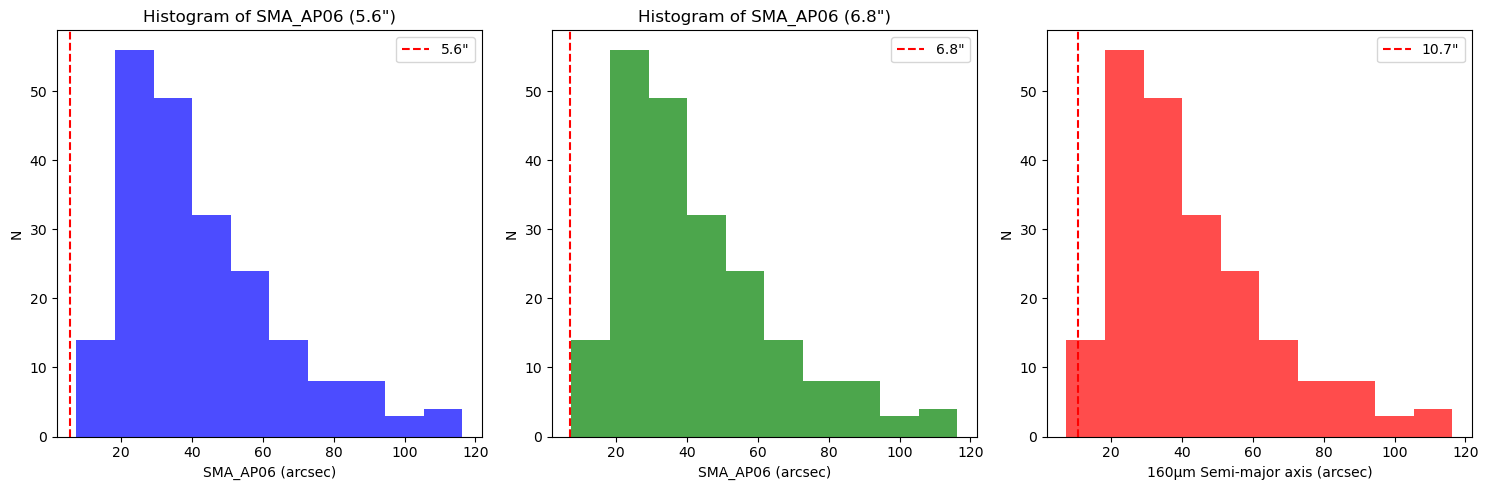

In [3]:

def rename_and_transform_columns(input_file, output_file):
    # Load the CSV file
    df = pd.read_csv(input_file)

    # Multiply SMA_AP06 by 0.262
    if 'SMA_AP06' in df.columns:
        df['SMA_AP06'] *= 0.262

    # Save the modified DataFrame to a new CSV file
    df.to_csv(output_file, index=False)

    print(f"File successfully written to {output_file}")
    return df  # Return the DataFrame for plotting

def plot_histograms(df):
    # Create subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Histogram for SMA_AP06 with vertical lines at specified values
    values = df['SMA_AP06'].dropna()  # Remove NaN values for plotting

    # Plot the histograms
    axs[0].hist(values, bins=10, color='blue', alpha=0.7)
    axs[0].axvline(5.6, color='red', linestyle='--', label='5.6"')
    axs[0].set_title('Histogram of SMA_AP06 (5.6")')
    axs[0].set_xlabel('SMA_AP06 (arcsec)')
    axs[0].set_ylabel('N')
    axs[0].legend()

    axs[1].hist(values, bins=10, color='green', alpha=0.7)
    axs[1].axvline(6.8, color='red', linestyle='--', label='6.8"')
    axs[1].set_title('Histogram of SMA_AP06 (6.8")')
    axs[1].set_xlabel('SMA_AP06 (arcsec)')
    axs[1].set_ylabel('N')
    axs[1].legend()

    axs[2].hist(values, bins=10, color='red', alpha=0.7)
    axs[2].axvline(10.7, color='red', linestyle='--', label='10.7"')
    #axs[2].set_title('Histogram of SMA_AP06 (10.7")')
    axs[2].set_xlabel('160µm Semi-major axis (arcsec)')
    axs[2].set_ylabel('N')
    axs[2].legend()

    plt.tight_layout()
    plt.savefig('psf_histogram.png', dpi=300, bbox_inches='tight')
    plt.show()

# Example usage
input_file = tabledir + 'Photometrytesting2.csv'  # Replace with the path to your input CSV file
output_file = 'noeh.csv'  # Replace with the path to your output CSV file

df = rename_and_transform_columns(input_file, output_file)
plot_histograms(df)
